# 그래프를 이용한 텍스트 분석 및 자연어 처리

아래의 코드는 인사이트를 식별하고 관련 정보를 추출하기 위한 문서 분석 및 그래프 분석 활용에 중점을 둔다.

특히 다음과 같은 방법을 설명할 것이다.

* NLP 기술 및 모델을 사용해 텍스트에서 구조화된 정보 추출
* 이전 지점에서 추출한 정보를 시작으로 다양한 유형의 그래프 작성
* 그래프 분석

### 데이터셋 불러오기

In [1]:
import nltk
nltk.download('reuters')

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\K\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

In [2]:
import numpy as np

import pandas as pd
import networkx as nx

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

In [4]:
from nltk.corpus import reuters

In [5]:
corpus = pd.DataFrame([
    {"id": _id, "clean_text": reuters.raw(_id).replace("\n", ""), "label": reuters.categories(_id)}
    for _id in reuters.fileids()
]).set_index("id")

In [6]:
corpus.iloc[10]["clean_text"]

'SUBROTO SAYS INDONESIA SUPPORTS TIN PACT EXTENSION  Mines and Energy Minister Subroto  confirmed Indonesian support for an extension of the sixth  International Tin Agreement (ITA), but said a new pact was not  necessary.      Asked by Reuters to clarify his statement on Monday in  which he said the pact should be allowed to lapse, Subroto said  Indonesia was ready to back extension of the ITA.      "We can support extension of the sixth agreement," he said.  "But a seventh accord we believe to be unnecessary."      The sixth ITA will expire at the end of June unless a  two-thirds majority of members vote for an extension.  '

In [7]:
from collections import Counter
len(Counter([label for document_labels in corpus["label"] for label in document_labels]).most_common())

90

In [8]:
corpus.head()

clean_text  \
id                                                              
test/14826  ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...   
test/14828  CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...   
test/14829  JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...   
test/14832  THAI TRADE DEFICIT WIDENS IN FIRST QUARTER  Th...   
test/14833  INDONESIA SEES CPO PRICE RISING SHARPLY  Indon...   

                                                     label  
id                                                          
test/14826                                         [trade]  
test/14828                                         [grain]  
test/14829                                [crude, nat-gas]  
test/14832  [corn, grain, rice, rubber, sugar, tin, trade]  
test/14833                             [palm-oil, veg-oil]

### 언어 감지

In [9]:
import langdetect

In [10]:
import numpy as np

def getLanguage(text: str):
    try:
        return langdetect.detect(text)
    except: 
        return np.nan

In [11]:
corpus["language"] = corpus["clean_text"].apply(getLanguage)

In [12]:
corpus["language"].value_counts().head(10)

en    9906
sv     429
de     372
sw      29
so      22
nl       8
pt       7
vi       5
et       4
ca       2
Name: language, dtype: int64

In [13]:
corpus.head()

clean_text  \
id                                                              
test/14826  ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...   
test/14828  CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...   
test/14829  JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...   
test/14832  THAI TRADE DEFICIT WIDENS IN FIRST QUARTER  Th...   
test/14833  INDONESIA SEES CPO PRICE RISING SHARPLY  Indon...   

                                                     label language  
id                                                                   
test/14826                                         [trade]       en  
test/14828                                         [grain]       en  
test/14829                                [crude, nat-gas]       en  
test/14832  [corn, grain, rice, rubber, sugar, tin, trade]       en  
test/14833                             [palm-oil, veg-oil]       en

Using fasttext

In [14]:
!curl -w GET https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz > lid.176.ftz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  916k    0  1589    0     0   1315      0  0:11:53  0:00:01  0:11:52  1316
100  916k  100  916k    0     0   437k      0  0:00:02  0:00:02 --:--:--  437k


In [15]:
import fasttext

m = fasttext.load_model("lid.176.ftz")
def getLanguage(text: str):
    return m.predict(text)[0][0].replace("__label__", "")

In [16]:
corpus["language"] = corpus["clean_text"].apply(getLanguage)

In [17]:
corpus["language"].value_counts().head(10)

en    10278
de       90
ja       73
it       67
sv       52
zh       48
es       31
fr       27
eu       20
eo       12
Name: language, dtype: int64

In [18]:
corpus[corpus["language"]=="ja"].iloc[5]["clean_text"]

'USDA - U.S. 1986/87 ENDING CORN STOCKS  5,240 MLN BU, WHEAT 1,848 MLN, SOYBEANS 610 MLN  USDA - U.S. 1986/87 ENDING CORN STOCKS  5,240 MLN BU, WHEAT 1,848 MLN, SOYBEANS 610 MLN  '

### NLP 강화

In [19]:
import spacy

Spacy 라이브러리에서 모델을 다운로드하려면 명령창에서 다음 명령을 실행 해야한다.

<pre><code>
python -m spacy download en_core_web_md
</code></pre>


In [20]:
nlp = spacy.load('en_core_web_md')

In [21]:
corpus["parsed"] = corpus["clean_text"].apply(nlp)

In [22]:
corpus.loc["test/14832"]["clean_text"]

"THAI TRADE DEFICIT WIDENS IN FIRST QUARTER  Thailand's trade deficit widened to 4.5  billion baht in the first quarter of 1987 from 2.1 billion a  year ago, the Business Economics Department said.      It said Janunary/March imports rose to 65.1 billion baht  from 58.7 billion. Thailand's improved business climate this  year resulted in a 27 pct increase in imports of raw materials  and semi-finished products.      The country's oil import bill, however, fell 23 pct in the  first quarter due to lower oil prices.      The department said first quarter exports expanded to 60.6  billion baht from 56.6 billion.      Export growth was smaller than expected due to lower  earnings from many key commodities including rice whose  earnings declined 18 pct, maize 66 pct, sugar 45 pct, tin 26  pct and canned pineapples seven pct.      Products registering high export growth were jewellery up  64 pct, clothing 57 pct and rubber 35 pct.  "

In [23]:
from spacy import displacy

In [24]:
displacy.render(corpus.loc["test/14832"]["parsed"], style='ent', jupyter=True)

#### 말뭉치 DataFrame 출력

In [25]:
corpus.head()

clean_text  \
id                                                              
test/14826  ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...   
test/14828  CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...   
test/14829  JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...   
test/14832  THAI TRADE DEFICIT WIDENS IN FIRST QUARTER  Th...   
test/14833  INDONESIA SEES CPO PRICE RISING SHARPLY  Indon...   

                                                     label language  \
id                                                                    
test/14826                                         [trade]       en   
test/14828                                         [grain]       en   
test/14829                                [crude, nat-gas]       en   
test/14832  [corn, grain, rice, rubber, sugar, tin, trade]       en   
test/14833                             [palm-oil, veg-oil]       en   

                                                       parsed  
id                                                             
test/14826  (ASIAN, EXPORTERS, FEAR, DAMAGE, FROM, U.S.-JA...  
test/14828  (CHINA, DAILY, SAYS, VERMIN, EAT, 7, -, 12, PC...  
test/14829  (JAPAN, TO, REVISE, LONG, -, TERM, ENERGY, DEM...  
test/14832  (THAI, TRADE, DEFICIT, WIDENS, IN, FIRST, QUAR...  
test/14833  (INDONESIA, SEES, CPO, PRICE, RISING, SHARPLY,...

In [26]:
corpus[["clean_text", "label", "language", "parsed"]].to_pickle("corpus.p")

## 그래프 생성

다음으로 문서 모음에서 두 가지 다른 종류의 그래프를 만드는 방법을 설명한다.

* 의미 그래프를 작성하기 위해 주어-동사-객체 관계가 인코딩된 지식 기반 그래프
* 이분 그래프, 문서에 나타나는 개체/키워드와 문서 연결

### 지식 기반

In [27]:
from subject_object_extraction import findSVOs

In [28]:
corpus["triplets"] = corpus["parsed"].apply(lambda x: findSVOs(x, output="obj"))

In [29]:
corpus.head()

clean_text  \
id                                                              
test/14826  ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...   
test/14828  CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...   
test/14829  JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...   
test/14832  THAI TRADE DEFICIT WIDENS IN FIRST QUARTER  Th...   
test/14833  INDONESIA SEES CPO PRICE RISING SHARPLY  Indon...   

                                                     label language  \
id                                                                    
test/14826                                         [trade]       en   
test/14828                                         [grain]       en   
test/14829                                [crude, nat-gas]       en   
test/14832  [corn, grain, rice, rubber, sugar, tin, trade]       en   
test/14833                             [palm-oil, veg-oil]       en   

                                                       parsed  \
id                                                              
test/14826  (ASIAN, EXPORTERS, FEAR, DAMAGE, FROM, U.S.-JA...   
test/14828  (CHINA, DAILY, SAYS, VERMIN, EAT, 7, -, 12, PC...   
test/14829  (JAPAN, TO, REVISE, LONG, -, TERM, ENERGY, DEM...   
test/14832  (THAI, TRADE, DEFICIT, WIDENS, IN, FIRST, QUAR...   
test/14833  (INDONESIA, SEES, CPO, PRICE, RISING, SHARPLY,...   

                                                     triplets  
id                                                             
test/14826  [(EXPORTERS, (FEAR, False), DAMAGE), (Japan, (...  
test/14828  [(VERMIN, (EAT, False), STOCKS), (vermin, (con...  
test/14829  [(JAPAN, (REVISE, False), DEMAND), (Industry, ...  
test/14832  [(Products, (registering, False), growth), (Pr...  
test/14833  [(INDONESIA, (SEES, False), PRICE), (Indonesia...

In [30]:
edge_list = [
    {"id": _id, "source": source.lemma_.lower(), "target": target.lemma_.lower(), "edge": edge.lemma_.lower()}
    for _id, triplets in corpus["triplets"].iteritems()
    for (source, (edge, neg), target) in triplets
]

In [31]:
edges = pd.DataFrame(edge_list)

In [32]:
edges["edge"].value_counts().head(10)

be         7620
have       2675
include    2010
tell       1729
buy        1464
sell       1385
say        1216
take       1172
make       1151
give       1029
Name: edge, dtype: int64

In [33]:
import networkx as nx

In [34]:
G=nx.from_pandas_edgelist(edges, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

In [35]:
len(G.nodes)

7576

In [36]:
def plotDistribution(serie: pd.Series, nbins: int, minValue=None, maxValue=None):
    _minValue=int(np.floor(np.log10(minValue if minValue is not None else serie.min())))
    _maxValue=int(np.ceil(np.log10(maxValue if maxValue is not None else serie.max())))
    bins = [0] + list(np.logspace(_minValue, _maxValue, nbins)) + [np.inf]
    serie.hist(bins=bins)
    plt.xscale("log")

In [37]:
def graphSummary(graph, bins=10):
    print(nx.info(graph))
    plt.figure(figsize=(20, 8))
    plt.subplot(1,2,1)
    degrees = pd.Series({k: v for k, v in nx.degree(graph)})
    plt.yscale("log")
    plotDistribution(degrees, bins)
    try:
        plt.subplot(1,2,2)
        allEdgesWeights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in graph.edges(data=True)})
        plotDistribution(allEdgesWeights, bins)
        plt.yscale("log")
    except:
        pass

In [38]:
print(nx.info(G))

Name: 
Type: MultiDiGraph
Number of nodes: 7576
Number of edges: 72263
Average in degree:   9.5384
Average out degree:   9.5384


Name: 
Type: MultiDiGraph
Number of nodes: 7576
Number of edges: 72263
Average in degree:   9.5384
Average out degree:   9.5384


C:\Users\K\.conda\envs\Graph_ML_38\lib\site-packages\matplotlib\axes\_axes.py:6703: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


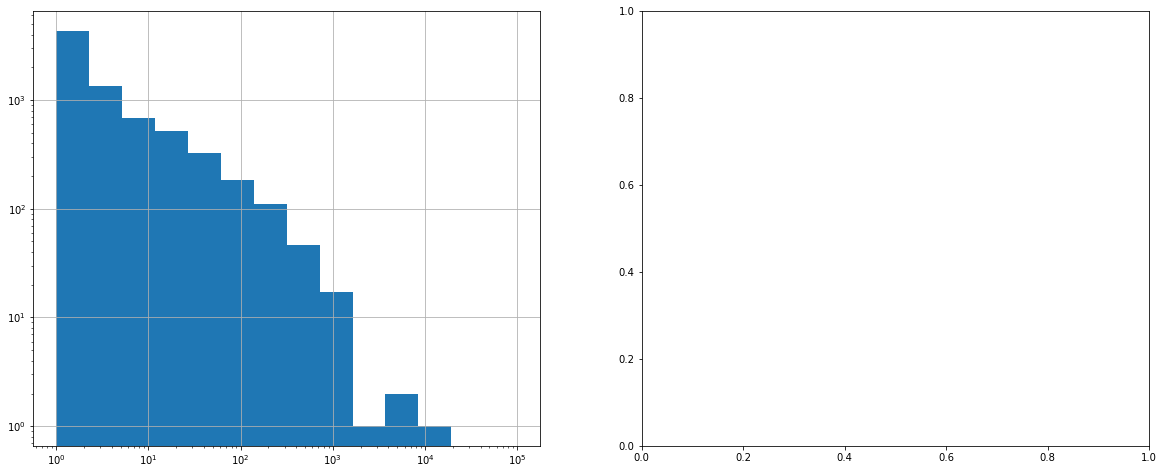

In [39]:
graphSummary(G, bins=15)

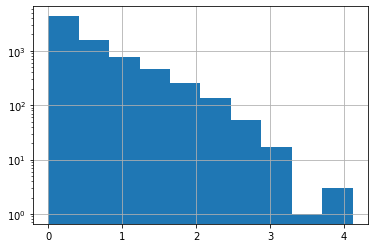

In [40]:
import numpy as np
np.log10(pd.Series({k: v for k, v in nx.degree(G)}).sort_values(ascending=False)).hist()
plt.yscale("log")

특정 관계 분석

In [41]:
edges.head()

id    source         target     edge
0  test/14826  exporter         damage     fear
1  test/14826     japan           fear    raise
2  test/14826       row         damage  inflict
3  test/14826      they  correspondent     tell
4  test/14826      they           u.s.     tell

In [42]:
e = edges[(edges["source"]!=" ") & (edges["target"]!=" ") & (edges["edge"]=="lend")]

In [43]:
G=nx.from_pandas_edgelist(e, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

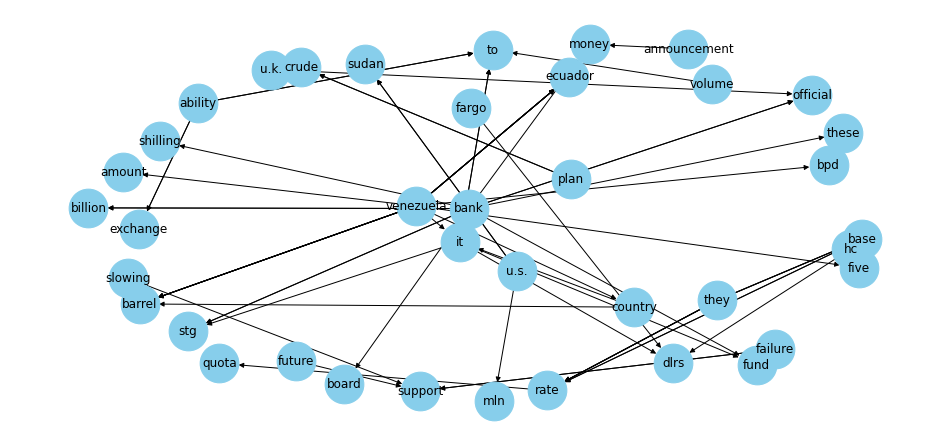

In [44]:
import os

plt.figure(figsize=(13, 6))

pos = nx.spring_layout(G, k=1.2) # k regulates the distance between nodes

nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos, font_size=12)

# plt.show()
# plt.savefig(os.path.join(".", "KnowledgeGraph.png"), dpi=300, format="png")

## 이분 그래프

문서에서 키워드를 추출하는 것으로 시작한다.

In [45]:
import gensim

In [46]:
from gensim.summarization import keywords 

In [47]:
text = corpus["clean_text"][0]
keywords(text, words=10, split=True, scores=True, pos_filter=('NN', 'JJ'), lemmatize=True)

[('trading', 0.46151306395385266),
 ('said', 0.31598556934945127),
 ('export', 0.2691553824958082),
 ('import', 0.1746201000645688),
 ('japanese electronics', 0.13609326263790328),
 ('industry', 0.12860437403797814),
 ('minister', 0.1222981566200044),
 ('japan', 0.11434500812642473),
 ('year', 0.10483992409352474)]

In [48]:
corpus["keywords"] = corpus["clean_text"].apply(
    lambda text: keywords(text, words=10, split=True, scores=True, pos_filter=('NN', 'JJ'), lemmatize=True)
)

In [49]:
corpus.head()

clean_text  \
id                                                              
test/14826  ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...   
test/14828  CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...   
test/14829  JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...   
test/14832  THAI TRADE DEFICIT WIDENS IN FIRST QUARTER  Th...   
test/14833  INDONESIA SEES CPO PRICE RISING SHARPLY  Indon...   

                                                     label language  \
id                                                                    
test/14826                                         [trade]       en   
test/14828                                         [grain]       en   
test/14829                                [crude, nat-gas]       en   
test/14832  [corn, grain, rice, rubber, sugar, tin, trade]       en   
test/14833                             [palm-oil, veg-oil]       en   

                                                       parsed  \
id                                                              
test/14826  (ASIAN, EXPORTERS, FEAR, DAMAGE, FROM, U.S.-JA...   
test/14828  (CHINA, DAILY, SAYS, VERMIN, EAT, 7, -, 12, PC...   
test/14829  (JAPAN, TO, REVISE, LONG, -, TERM, ENERGY, DEM...   
test/14832  (THAI, TRADE, DEFICIT, WIDENS, IN, FIRST, QUAR...   
test/14833  (INDONESIA, SEES, CPO, PRICE, RISING, SHARPLY,...   

                                                     triplets  \
id                                                              
test/14826  [(EXPORTERS, (FEAR, False), DAMAGE), (Japan, (...   
test/14828  [(VERMIN, (EAT, False), STOCKS), (vermin, (con...   
test/14829  [(JAPAN, (REVISE, False), DEMAND), (Industry, ...   
test/14832  [(Products, (registering, False), growth), (Pr...   
test/14833  [(INDONESIA, (SEES, False), PRICE), (Indonesia...   

                                                     keywords  
id                                                             
test/14826  [(trading, 0.46151306395385366), (said, 0.3159...  
test/14828  [(vermin, 0.3120614380287174), (daily, 0.26110...  
test/14829  [(energy, 0.38576360926601205), (demand, 0.347...  
test/14832  [(pct, 0.5457455609144304), (export, 0.2656069...  
test/14833  [(indonesia, 0.2410428235502935), (harahap, 0....

In [50]:
def extractEntities(ents, minValue=1, typeFilters=["GPE", "ORG", "PERSON"]):
    entities = pd.DataFrame([
        {"lemma": e.lemma_, "lower": e.lemma_.lower(), "type": e.label_}
        for e in ents if hasattr(e, "label_")
    ])

    if len(entities)==0:
        return pd.DataFrame()
    
    g = entities.groupby(["type", "lower"])

    summary = pd.concat({
        "alias": g.apply(lambda x: x["lemma"].unique()), 
        "count": g["lower"].count()
    }, axis=1)
    
    return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]

def getOrEmpty(parsed, _type):
    try:
        return list(parsed.loc[_type]["count"].sort_values(ascending=False).to_dict().items())
    except:
        return []

def toField(ents):
    typeFilters=["GPE", "ORG", "PERSON"]
    parsed = extractEntities(ents, 1, typeFilters)
    return pd.Series({_type: getOrEmpty(parsed, _type) for _type in typeFilters})
    

In [51]:
entities = corpus["parsed"].apply(lambda x: toField(x.ents))

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]
C:\Users\K\AppData\Local\Temp\ipykernel_1556\3840139809.py:17: FutureWarni

In [52]:
merged = pd.concat([corpus, entities], axis=1) 

In [53]:
merged.head()

clean_text  \
id                                                              
test/14826  ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...   
test/14828  CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...   
test/14829  JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...   
test/14832  THAI TRADE DEFICIT WIDENS IN FIRST QUARTER  Th...   
test/14833  INDONESIA SEES CPO PRICE RISING SHARPLY  Indon...   

                                                     label language  \
id                                                                    
test/14826                                         [trade]       en   
test/14828                                         [grain]       en   
test/14829                                [crude, nat-gas]       en   
test/14832  [corn, grain, rice, rubber, sugar, tin, trade]       en   
test/14833                             [palm-oil, veg-oil]       en   

                                                       parsed  \
id                                                              
test/14826  (ASIAN, EXPORTERS, FEAR, DAMAGE, FROM, U.S.-JA...   
test/14828  (CHINA, DAILY, SAYS, VERMIN, EAT, 7, -, 12, PC...   
test/14829  (JAPAN, TO, REVISE, LONG, -, TERM, ENERGY, DEM...   
test/14832  (THAI, TRADE, DEFICIT, WIDENS, IN, FIRST, QUAR...   
test/14833  (INDONESIA, SEES, CPO, PRICE, RISING, SHARPLY,...   

                                                     triplets  \
id                                                              
test/14826  [(EXPORTERS, (FEAR, False), DAMAGE), (Japan, (...   
test/14828  [(VERMIN, (EAT, False), STOCKS), (vermin, (con...   
test/14829  [(JAPAN, (REVISE, False), DEMAND), (Industry, ...   
test/14832  [(Products, (registering, False), growth), (Pr...   
test/14833  [(INDONESIA, (SEES, False), PRICE), (Indonesia...   

                                                     keywords  \
id                                                              
test/14826  [(trading, 0.46151306395385366), (said, 0.3159...   
test/14828  [(vermin, 0.3120614380287174), (daily, 0.26110...   
test/14829  [(energy, 0.38576360926601205), (demand, 0.347...   
test/14832  [(pct, 0.5457455609144304), (export, 0.2656069...   
test/14833  [(indonesia, 0.2410428235502935), (harahap, 0....   

                                                          GPE         ORG  \
id                                                                          
test/14826  [(u.s., 13), (japan, 12), (taiwan, 3), (austra...          []   
test/14828                                       [(china, 2)]          []   
test/14829                                       [(japan, 2)]          []   
test/14832                                    [(thailand, 2)]          []   
test/14833                    [(indonesia, 4), (malaysia, 2)]  [(cpo, 2)]   

           PERSON  
id                 
test/14826     []  
test/14828     []  
test/14829     []  
test/14832     []  
test/14833     []

드디어 이분 그래프를 생성한다.

In [157]:
edges = pd.DataFrame([
    {"source": _id, "target": keyword, "weight": score, "type": _type}
    for _id, row in merged.iterrows()
    for _type in ["keywords", "GPE", "ORG", "PERSON"] 
    for (keyword, score) in row[_type]
])
edges.to_pickle("bipartiteEdges.p")

In [55]:
G = nx.Graph()
G.add_nodes_from(edges["source"].unique(), bipartite=0)
G.add_nodes_from(edges["target"].unique(), bipartite=1)
G.add_edges_from([
    (row["source"], row["target"])
    for _, row in edges.iterrows()
])

In [56]:
document_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
entity_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 1}

In [57]:
nodes_with_low_degree = {n for n, d in nx.degree(G, nbunch=entity_nodes) if d<5}

In [58]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 25780
Number of edges: 100309
Average degree:   7.7819


In [59]:
from networkx.algorithms.bipartite.projection import overlap_weighted_projected_graph

### 개체-개체 그래프 투영

In [60]:
subGraph = G.subgraph(set(G.nodes) - nodes_with_low_degree)

In [61]:
entityGraph = overlap_weighted_projected_graph(
    subGraph, 
    {n for n, d in subGraph.nodes(data=True) if d["bipartite"] == 1}
)

In [62]:
len(entityGraph.nodes())

2383

In [63]:
degrees = pd.Series({k: v for k, v in nx.degree(entityGraph)})

C:\Users\K\.conda\envs\Graph_ML_38\lib\site-packages\matplotlib\axes\_axes.py:6703: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


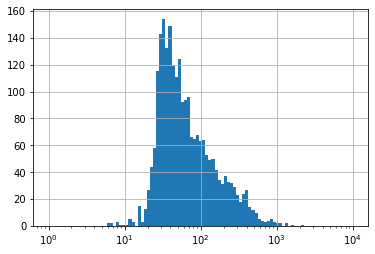

In [64]:
plotDistribution(degrees, 100)

In [65]:
print(nx.info(entityGraph))

Name: 
Type: Graph
Number of nodes: 2383
Number of edges: 120144
Average degree: 100.8342


In [66]:
allEdgesWeights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in entityGraph.edges(data=True)})

C:\Users\K\.conda\envs\Graph_ML_38\lib\site-packages\matplotlib\axes\_axes.py:6703: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


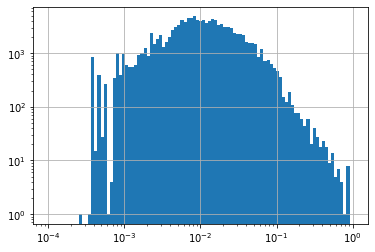

In [67]:
plotDistribution(allEdgesWeights, 100)
plt.yscale("log")

In [68]:
filteredEntityGraph = entityGraph.edge_subgraph(
    [edge for edge in entityGraph.edges if entityGraph.edges[edge]["weight"]>0.05]
)

In [69]:
print(nx.info(filteredEntityGraph))

Name: 
Type: Graph
Number of nodes: 2269
Number of edges: 8060
Average degree:   7.1045


#### 그래프의 지역 및 전역 속성

In [70]:
globalKpis = [{
    "shortest_path": nx.average_shortest_path_length(_graph),
    "clustering_coefficient": nx.average_clustering(_graph),
    "global_efficiency": nx.global_efficiency(_graph)
} for components in nx.connected_components(filteredEntityGraph) 
    for _graph in [nx.subgraph(filteredEntityGraph, components)]]

In [71]:
pd.concat([
    pd.DataFrame(globalKpis), 
    pd.Series([len(c) for c in nx.connected_components(filteredEntityGraph)])
], axis=1)

shortest_path  clustering_coefficient  global_efficiency     0
0       4.719537                0.213821           0.227064  2260
1       1.000000                0.000000           1.000000     2
2       1.600000                0.000000           0.700000     5
3       1.000000                0.000000           1.000000     2

In [72]:
pd.Series([len(c) for c in nx.connected_components(filteredEntityGraph)]).sum()

2269

In [73]:
globalKpis[0]

{'shortest_path': 4.719536798724473,
 'clustering_coefficient': 0.2138213711969244,
 'global_efficiency': 0.22706424557581228}

In [74]:
# nx.write_gexf(filteredEntityGraph, "filteredEntityGraph.gexf")

In [75]:
betweeness = nx.betweenness_centrality(filteredEntityGraph)

In [76]:
_betweeness = pd.Series(betweeness)

C:\Users\K\.conda\envs\Graph_ML_38\lib\site-packages\matplotlib\axes\_axes.py:6703: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


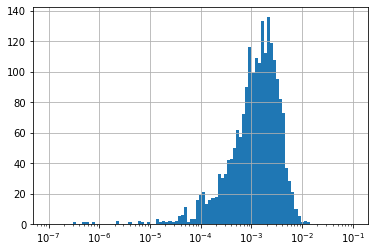

In [77]:
plotDistribution(_betweeness[_betweeness>0], 100)

In [78]:
pageRanks = pd.Series(nx.pagerank(filteredEntityGraph))

In [79]:
degrees = pd.Series({k: v for k, v in nx.degree(filteredEntityGraph)})

In [80]:
kpis = pd.concat({
    "pageRank": pageRanks, 
    "degrees": degrees, 
    "betweeness": _betweeness
}, axis=1)

(1e-05, 0.02)

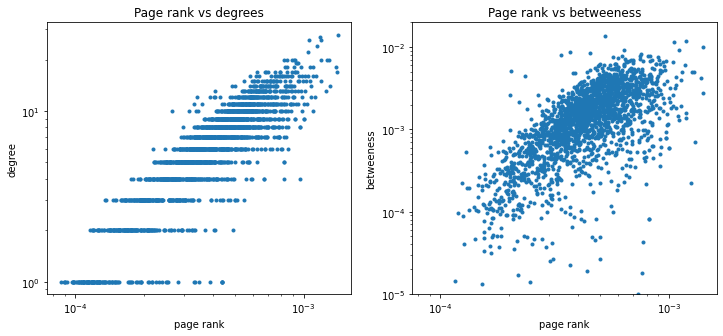

In [81]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.title("Page rank vs degrees")
plt.plot(kpis["pageRank"], kpis["degrees"], '.', color="tab:blue")
plt.xlabel("page rank")
plt.ylabel("degree")
plt.xscale("log")
plt.yscale("log")

plt.subplot(1,2,2)
plt.title("Page rank vs betweeness")
plt.plot(kpis["pageRank"], kpis["betweeness"], '.', color="tab:blue")
plt.xlabel("page rank")
plt.ylabel("betweeness")
plt.xscale("log")
plt.yscale("log")
plt.ylim([1E-5, 2E-2])

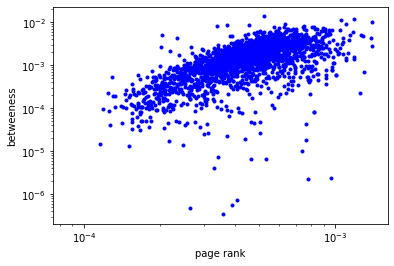

In [82]:
plt.figure(figsize=(6,4))
plt.plot(kpis["pageRank"], kpis["betweeness"], 'b.')
plt.xlabel("page rank")
plt.ylabel("betweeness")
plt.xscale("log")
plt.yscale("log")

C:\Users\K\.conda\envs\Graph_ML_38\lib\site-packages\matplotlib\axes\_axes.py:6703: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


Text(0.5, 1.0, 'Edge Weight Distribution')

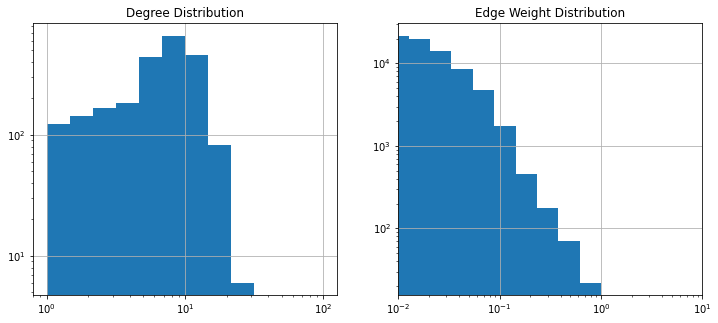

In [83]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plotDistribution(degrees, 13)
plt.yscale("log")
plt.title("Degree Distribution")

plt.subplot(1,2,2)
plotDistribution(allEdgesWeights, 20)
plt.xlim([1E-2, 10])
plt.yscale("log")
plt.title("Edge Weight Distribution")


In [84]:
allEdgesWeights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in filteredEntityGraph.edges(data=True)})

C:\Users\K\.conda\envs\Graph_ML_38\lib\site-packages\matplotlib\axes\_axes.py:6703: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


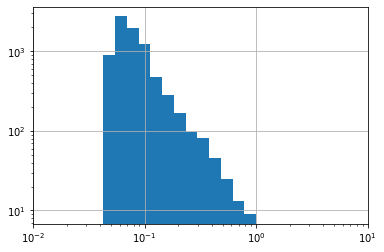

In [85]:
plotDistribution(allEdgesWeights, 20)
plt.xlim([1E-2, 10])
plt.yscale("log")

#### 네트워크 시각화

In [86]:
#Create network layout for visualizations
spring_pos = nx.spring_layout(filteredEntityGraph)

In [87]:
default_edge_color = 'gray'
default_node_color = '#407cc9'
enhanced_node_color = '#f5b042'
enhanced_edge_color = '#cc2f04'

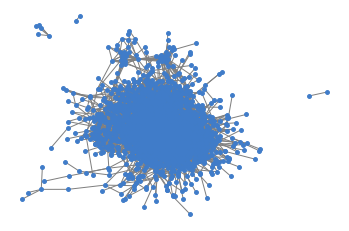

In [88]:
plt.axis("off")
nx.draw_networkx(filteredEntityGraph, pos=spring_pos, node_color=default_node_color, 
                 edge_color=default_edge_color, with_labels=False, node_size=15)

#### 커뮤니티 감지

In [89]:
import community

In [90]:
communities = pd.Series(community.best_partition(filteredEntityGraph))

Text(0, 0.5, '# Members')

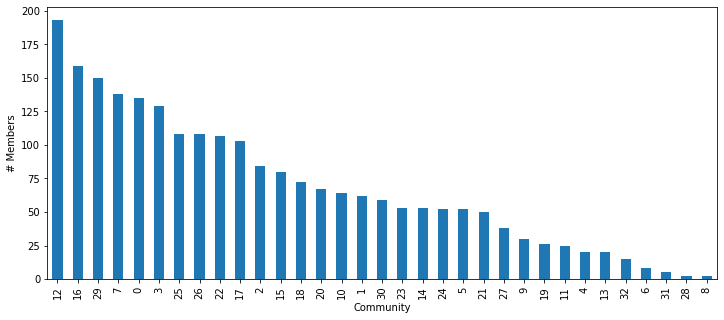

In [91]:
communities.value_counts().sort_values(ascending=False).plot(kind="bar", figsize=(12, 5))
plt.xlabel("Community")
plt.ylabel("# Members")

In [92]:
communities.loc["turkish"]

7

In [93]:
nodes = communities[communities==17].index

In [94]:
nodes

Index(['allegheny', 'carryforward', 'railway', 'subordinated', 'suit',
       'affiliate', 'regional', 'quebec', 'supplies', 'mint',
       ...
       'periods ended', 'philadelphia', 'originally', 'eagle', 'first boston',
       'glass', 'smaller', 'edison', 'gold', 'platinum'],
      dtype='object', length=103)

In [95]:
smallGrap = nx.subgraph(filteredEntityGraph, nbunch=nodes)

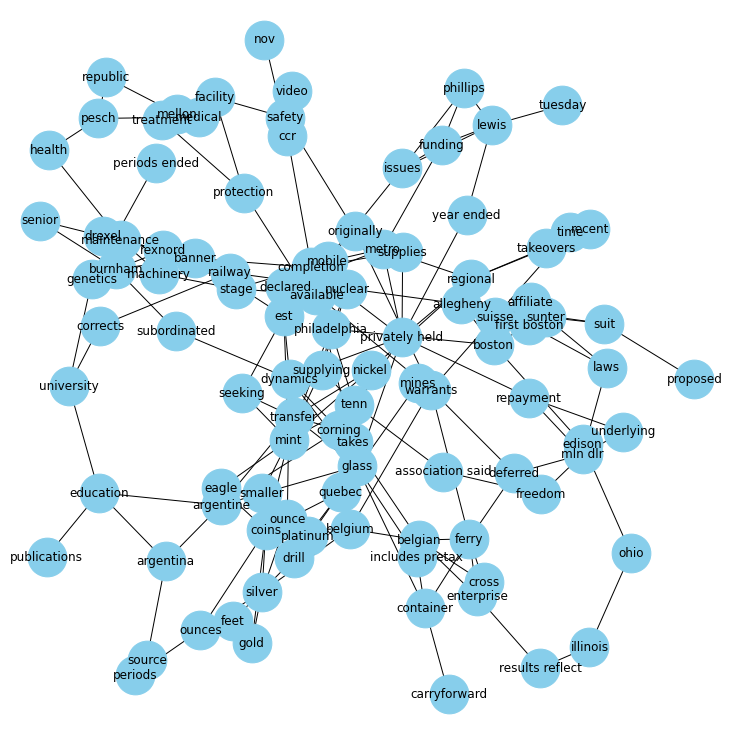

In [96]:
plt.figure(figsize=(10,10))

pos = nx.spring_layout(smallGrap) # k regulates the distance between nodes

nx.draw(smallGrap, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)

# plt.show()
# plt.savefig(os.path.join(".", "CloseUp.png"), dpi=300, format="png")

클러스터의 이분 근접

In [97]:
bipartiteCloseup = subGraph.edge_subgraph(
    {e for e in subGraph.edges() if len(set(e).intersection(nodes))>0}
)

deg = nx.degree(bipartiteCloseup)

smallGrap = nx.subgraph(bipartiteCloseup, {n for n, d in bipartiteCloseup.nodes(data=True) if d["bipartite"]==1 or deg[n]>1})

In [98]:
len([n for n, d in bipartiteCloseup.nodes(data=True) if d["bipartite"]==0])

953

In [99]:
len(nodes)

103

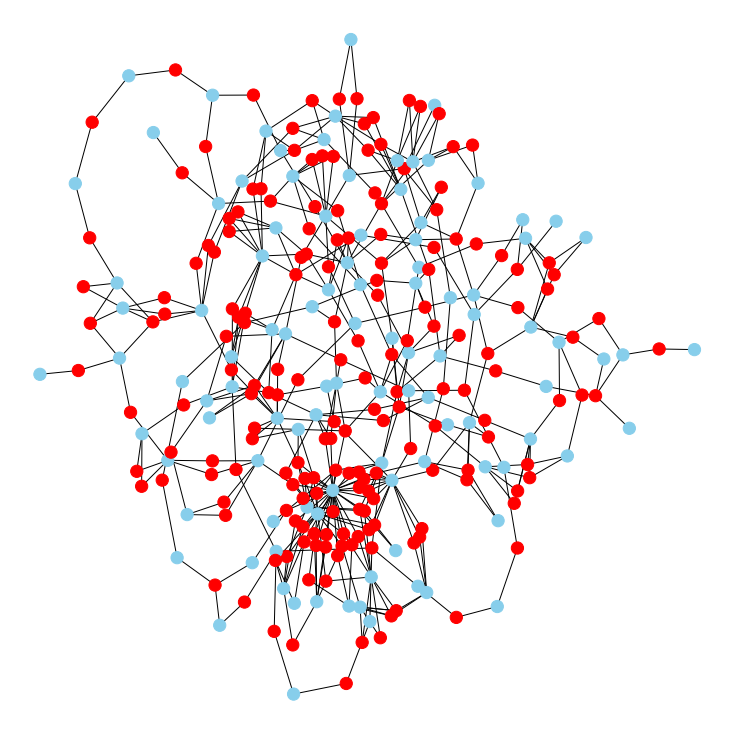

In [100]:
plt.figure(figsize=(10,10))

pos = nx.kamada_kawai_layout(smallGrap) # k regulates the distance between nodes

node_color = ["skyblue" if d["bipartite"]==1 else "red" for n, d in smallGrap.nodes(data=True)]

nx.draw(smallGrap, with_labels=False, node_color=node_color, #'skyblue', 
        node_size=150, edge_cmap=plt.cm.Blues, pos = pos)


# plt.show()
# plt.savefig(os.path.join(".", "BipartiteCloseUp.png"), dpi=300, format="png")

#### 임베딩

TSNE

In [101]:
from node2vec import Node2Vec

node2vec = Node2Vec(filteredEntityGraph, dimensions=5) 
model = node2vec.fit(window=10) 
embeddings = model.wv 

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [01:15<00:00,  7.51s/it]


In [102]:
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2)
embedding2d=tsne.fit_transform(embeddings.vectors)

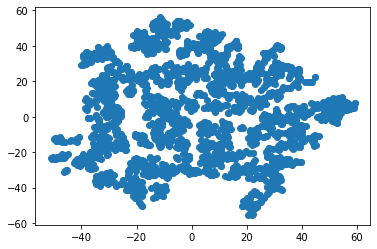

In [103]:
plt.plot(embedding2d[:, 0], embedding2d[:, 1], 'o')

Node2Vec

Node2Vec으로 개체 간의 유사도를 구할 수 있다.

In [104]:
embeddings.most_similar(positive=["turkey"])

[('ruling', 0.998619556427002),
 ('needed', 0.9979334473609924),
 ('athens', 0.990166425704956),
 ('reducing', 0.9888264536857605),
 ('act', 0.9855939149856567),
 ('greece', 0.983671247959137),
 ('met', 0.9702304005622864),
 ('mark', 0.9668000936508179),
 ('central', 0.9655029773712158),
 ('customs', 0.9641954302787781)]

### 문서-문서 그래프 투영

In [105]:
from networkx.algorithms.bipartite.projection import overlap_weighted_projected_graph

In [106]:
documentGraph = overlap_weighted_projected_graph(
    G, 
    {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
)

In [107]:
from matplotlib import pyplot as plt

In [108]:
print(nx.info(documentGraph))

Name: 
Type: Graph
Number of nodes: 10788
Number of edges: 12961025
Average degree: 2402.8597


In [109]:
degrees = pd.Series({k: v for k, v in nx.degree(documentGraph)})

C:\Users\K\.conda\envs\Graph_ML_38\lib\site-packages\matplotlib\axes\_axes.py:6703: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


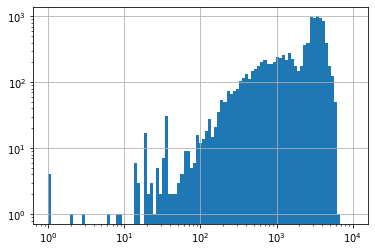

In [110]:
plotDistribution(degrees, 100)
plt.yscale("log")

In [111]:
allEdgesWeights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in documentGraph.edges(data=True)})

C:\Users\K\.conda\envs\Graph_ML_38\lib\site-packages\matplotlib\axes\_axes.py:6703: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


(0.01, 1)

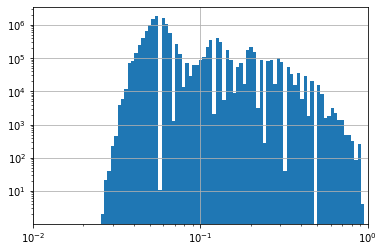

In [112]:
plotDistribution(allEdgesWeights, 100)
plt.yscale("log")
plt.xlim([1E-2, 1])

Text(0.5, 1.0, 'Edge Weight Distribution')

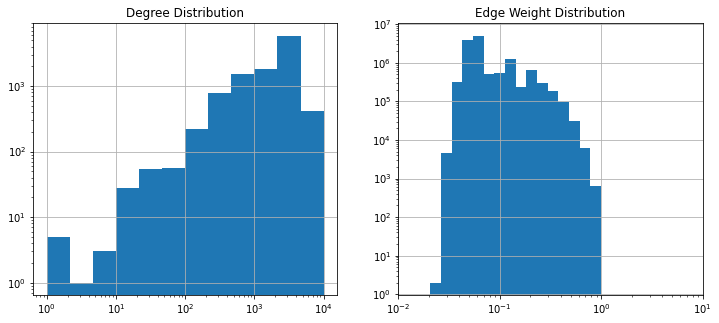

In [113]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plotDistribution(degrees, 13)
plt.yscale("log")
plt.title("Degree Distribution")

plt.subplot(1,2,2)
plotDistribution(allEdgesWeights, 20)
plt.xlim([1E-2, 10])
plt.yscale("log")
plt.title("Edge Weight Distribution")

In [114]:
filteredDocumentGraph = documentGraph.edge_subgraph(
    allEdgesWeights[(allEdgesWeights>0.6)].index.tolist()
)

In [115]:
print(nx.info(filteredDocumentGraph))

Name: 
Type: Graph
Number of nodes: 1960
Number of edges: 7873
Average degree:   8.0337


#### 전역 및 지역 속성

In [116]:
degrees = pd.Series({k: v for k, v in nx.degree(filteredDocumentGraph)})

C:\Users\K\.conda\envs\Graph_ML_38\lib\site-packages\matplotlib\axes\_axes.py:6703: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


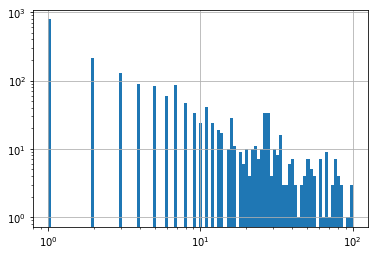

In [117]:
plotDistribution(degrees, 100)
plt.yscale("log")

In [118]:
allEdgesWeights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in filteredDocumentGraph.edges(data=True)})

C:\Users\K\.conda\envs\Graph_ML_38\lib\site-packages\matplotlib\axes\_axes.py:6703: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


(0.1, 1)

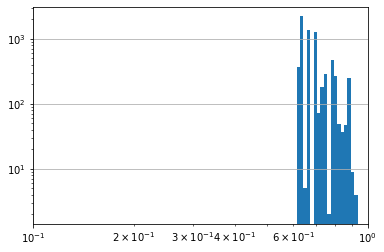

In [119]:
plotDistribution(allEdgesWeights, 100)
plt.yscale("log")
plt.xlim([1E-1, 1])

Text(0.5, 1.0, 'Edge Weight Distribution')

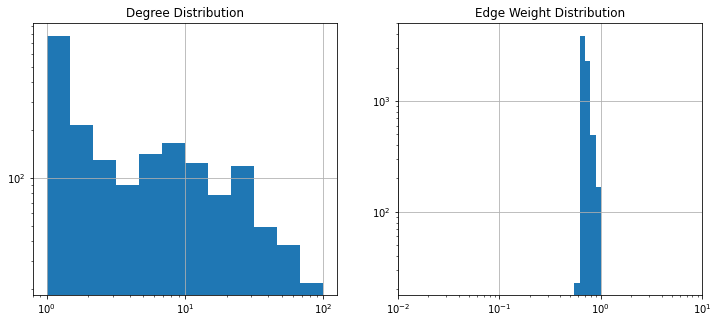

In [120]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plotDistribution(degrees, 13)
plt.yscale("log")
plt.title("Degree Distribution")

plt.subplot(1,2,2)
plotDistribution(allEdgesWeights, 20)
plt.xlim([1E-2, 10])
plt.yscale("log")
plt.title("Edge Weight Distribution")

#### 코어 - 주변부 설명 및 분석

In [121]:
#Create network layout for visualizations
spring_pos = nx.spring_layout(filteredDocumentGraph)

In [122]:
default_edge_color = 'gray'
default_node_color = '#407cc9'
enhanced_node_color = '#f5b042'
enhanced_edge_color = '#cc2f04'

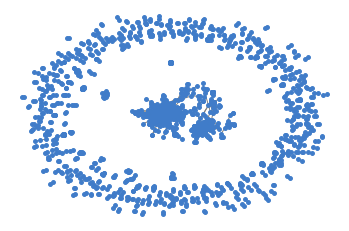

In [123]:
plt.axis("off")
nx.draw_networkx(filteredDocumentGraph, pos=spring_pos, node_color=default_node_color, 
                 edge_color=default_edge_color, with_labels=False, node_size=15)

In [124]:
components = pd.Series({ith: component 
              for ith, component in enumerate(nx.connected_components(filteredDocumentGraph))})

C:\Users\K\.conda\envs\Graph_ML_38\lib\site-packages\matplotlib\axes\_axes.py:6703: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


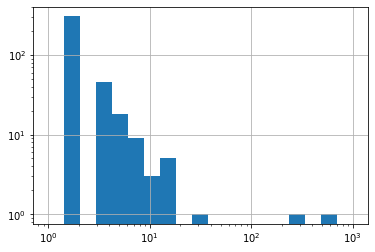

In [125]:
plotDistribution(components.apply(len), nbins=20)
plt.yscale("log")

In [126]:
coreDocumentGraph = nx.subgraph(
    filteredDocumentGraph,
    [node for nodes in components[components.apply(len)>8].values for node in nodes]
)

In [127]:
print(nx.info(coreDocumentGraph))

Name: 
Type: Graph
Number of nodes: 1030
Number of edges: 7059
Average degree:  13.7068


In [128]:
degrees = pd.Series({k: v for k, v in nx.degree(coreDocumentGraph)})

C:\Users\K\.conda\envs\Graph_ML_38\lib\site-packages\matplotlib\axes\_axes.py:6703: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


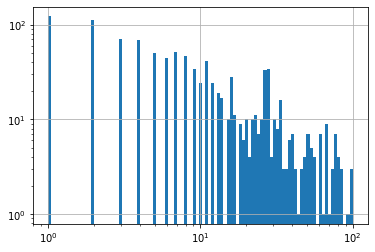

In [129]:
plotDistribution(degrees, 100)
plt.yscale("log")

In [130]:
allEdgesWeights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in coreDocumentGraph.edges(data=True)})

C:\Users\K\.conda\envs\Graph_ML_38\lib\site-packages\matplotlib\axes\_axes.py:6703: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


(0.1, 1)

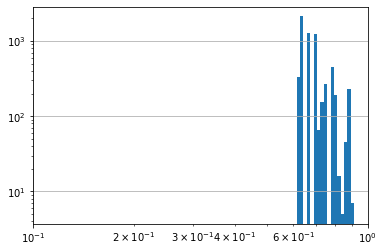

In [131]:
plotDistribution(allEdgesWeights, 100)
plt.yscale("log")
plt.xlim([1E-1, 1])

In [132]:
#Create network layout for visualizations
spring_pos = nx.spring_layout(coreDocumentGraph)

In [133]:
default_edge_color = 'gray'
default_node_color = '#407cc9'
enhanced_node_color = '#f5b042'
enhanced_edge_color = '#cc2f04'

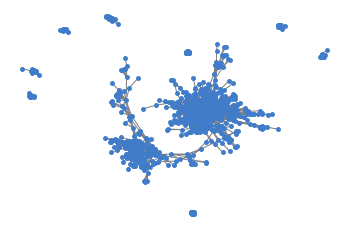

In [134]:
plt.axis("off")
nx.draw_networkx(coreDocumentGraph, pos=spring_pos, node_color=default_node_color, 
                 edge_color=default_edge_color, with_labels=False, node_size=15)

#### 커뮤니티 감지 및 주제 클러스터링

In [135]:
import community

In [136]:
communities = pd.Series(community.best_partition(coreDocumentGraph))

In [137]:
communities = pd.Series(community.best_partition(filteredDocumentGraph))

In [138]:
from collections import Counter

def getTopicRatio(df):
    return Counter([label for labels in df["label"] for label in labels])

In [139]:
communityTopics = pd.DataFrame.from_dict({
    cid: getTopicRatio(corpus.loc[comm.index])
    for cid, comm in communities.groupby(communities)
}, orient="index")

In [140]:
normalizedCommunityTopics = (communityTopics.T / communityTopics.sum(axis=1)).T

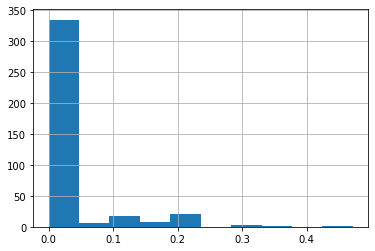

In [141]:
normalizedCommunityTopics.std(axis=1).fillna(0).hist()

Text(0.5, 0, 'Entropy')

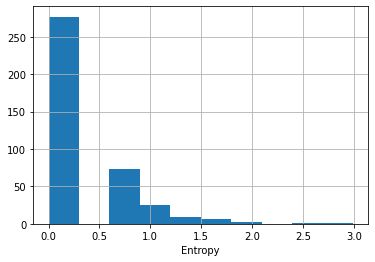

In [142]:
normalizedCommunityTopics.apply(lambda x: np.mean(-np.log(x)), axis=1).hist()
plt.xlabel("Entropy")

In [143]:
topicsCorrelation = normalizedCommunityTopics.corr().fillna(0)
topicsCorrelation[topicsCorrelation<0.8]=0


In [144]:
topicsGraph = nx.from_pandas_adjacency(topicsCorrelation)

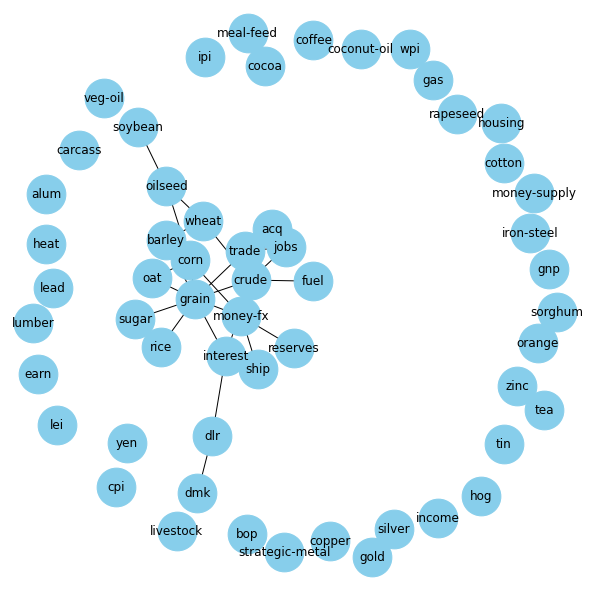

In [145]:
plt.figure(figsize=(8,8))

pos = nx.spring_layout(topicsGraph, k=0.35) # k regulates the distance between nodes

nx.draw(topicsGraph, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)

# plt.show()
# plt.savefig(os.path.join(".", "TopicsAll.png"), dpi=300, format="png")

In [146]:
filteredTopicsGraph = nx.subgraph(
    topicsGraph,
    [node for component in nx.connected_components(topicsGraph) if len(component)>3 for node in component]
)

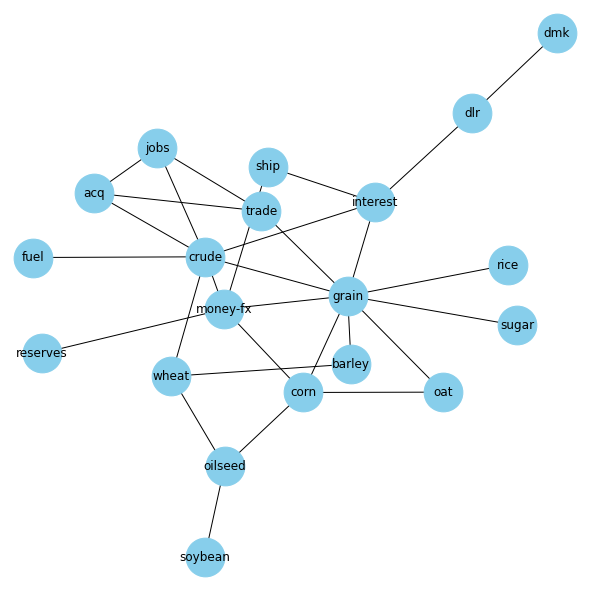

In [147]:
plt.figure(figsize=(8,8))

pos = nx.kamada_kawai_layout(filteredTopicsGraph) # k regulates the distance between nodes

nx.draw(filteredTopicsGraph, with_labels=True, node_color='skyblue', node_size=1500, 
        edge_cmap=plt.cm.Blues, pos = pos)

# plt.show()
# plt.savefig(os.path.join(".", "TopicsCore.png"), dpi=300, format="png")

#### 문서-문서 그래프 임베딩

In [148]:
from node2vec import Node2Vec

node2vec = Node2Vec(coreDocumentGraph, dimensions=20) 
model = node2vec.fit(window=10) 
embeddings = model.wv 

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.09s/it]


In [149]:
from sklearn.manifold import TSNE

tsne=TSNE(n_components=2)

In [150]:
embedding2d=tsne.fit_transform(embeddings.vectors)

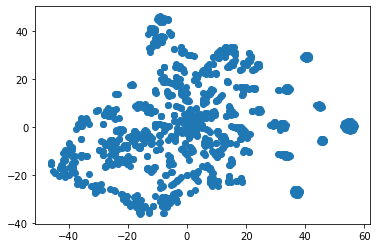

In [151]:
plt.plot(embedding2d[:, 0], embedding2d[:, 1], 'o')

In [152]:
pd.DataFrame(embeddings.vectors)

0         1         2         3         4         5         6   \
0     0.740253 -5.930679 -5.250119 -4.142614  0.631058  2.233762 -3.059815   
1     0.621176 -6.170752 -5.209810 -4.190358  0.812202  1.748626 -3.840800   
2     0.474400 -6.100180 -4.980587 -3.866998  1.310720  2.094756 -2.922120   
3    -2.261903 -5.258881 -2.712906 -5.876984 -2.313889  4.643165 -1.056463   
4    -1.277982 -5.103571 -1.603683 -2.427557 -1.567462  3.214323 -2.812428   
...        ...       ...       ...       ...       ...       ...       ...   
1025  0.408329 -0.533753  0.493608  0.630874  0.463990 -0.856032  0.463478   
1026  0.611068 -0.348471 -0.325257 -0.410623  0.209731 -0.498456  0.370844   
1027  0.373909  0.210781 -0.062124  0.537669  0.820524  0.282288  1.230754   
1028  0.326519  0.573996  0.132809  0.655120 -0.184773 -0.123505  0.531765   
1029  0.309320  0.259510 -0.081015  0.806807  1.576223  0.065950 -0.083028   

            7         8         9         10        11        12        13  \
0     0.883810  0.806349 -0.925387  4.358305  1.933046 -2.021148 -1.220328   
1     0.757462  0.920825 -1.681833  4.009306  1.503810 -1.671783 -1.063960   
2     0.799615  1.113028 -1.520300  4.090884  1.701992 -1.546802 -1.325317   
3    -1.226892  4.950229 -0.651304  3.738825 -1.265926 -1.270869  1.584729   
4     1.588130  3.908922 -2.870203  4.439369 -0.561473 -2.613359 -1.174101   
...        ...       ...       ...       ...       ...       ...       ...   
1025  0.112028 -0.342478 -0.270161 -1.077379 -0.587985  0.316623 -0.105690   
1026  0.463478 -0.569616  0.945957 -0.420302  0.019951  0.111511  0.203123   
1027  0.498097 -0.841221  0.207523 -1.374195  0.227418 -0.576449 -0.376422   
1028 -0.258363 -0.369124 -0.432198 -0.402635 -0.034559 -0.338865 -0.220303   
1029 -0.560098 -0.771302 -0.470331 -0.207172  0.882502 -0.478381  0.352745   

            14        15        16        17        18        19  
0     0.646417  4.893408  0.231346  3.496566 -0.179930  2.544335  
1     0.644329  5.228226  0.723316  3.216023 -0.169610  2.607317  
2     0.483989  5.250957  0.513105  2.788709 -0.069711  2.506517  
3    -2.854738 -1.353431 -0.697983  0.118727  0.752666  1.616526  
4    -0.753754  2.007094  3.230304  0.426672  0.616839  1.788934  
...        ...       ...       ...       ...       ...       ...  
1025 -0.196723  0.220403 -0.326753  0.123376  0.293115 -0.882354  
1026 -0.043286 -0.137893 -0.276707 -0.197017 -0.297680 -0.848029  
1027  0.349633 -0.303694  1.159712  0.267594 -0.460909 -0.340643  
1028 -0.337893 -0.278451 -0.513613 -0.350083  0.103979  0.421697  
1029  0.444403  0.109832  0.418186  0.600959 -0.299704 -0.822544  

[1030 rows x 20 columns]

In [153]:
pd.DataFrame(embeddings.vectors, index=embeddings.index2word)

0         1         2         3         4         5   \
test/20442      0.740253 -5.930679 -5.250119 -4.142614  0.631058  2.233762   
test/20221      0.621176 -6.170752 -5.209810 -4.190358  0.812202  1.748626   
test/20368      0.474400 -6.100180 -4.980587 -3.866998  1.310720  2.094756   
test/16715     -2.261903 -5.258881 -2.712906 -5.876984 -2.313889  4.643165   
test/21227     -1.277982 -5.103571 -1.603683 -2.427557 -1.567462  3.214323   
...                  ...       ...       ...       ...       ...       ...   
training/10499  0.408329 -0.533753  0.493608  0.630874  0.463990 -0.856032   
training/9652   0.611068 -0.348471 -0.325257 -0.410623  0.209731 -0.498456   
training/4956   0.373909  0.210781 -0.062124  0.537669  0.820524  0.282288   
training/11154  0.326519  0.573996  0.132809  0.655120 -0.184773 -0.123505   
training/1134   0.309320  0.259510 -0.081015  0.806807  1.576223  0.065950   

                      6         7         8         9         10        11  \
test/20442     -3.059815  0.883810  0.806349 -0.925387  4.358305  1.933046   
test/20221     -3.840800  0.757462  0.920825 -1.681833  4.009306  1.503810   
test/20368     -2.922120  0.799615  1.113028 -1.520300  4.090884  1.701992   
test/16715     -1.056463 -1.226892  4.950229 -0.651304  3.738825 -1.265926   
test/21227     -2.812428  1.588130  3.908922 -2.870203  4.439369 -0.561473   
...                  ...       ...       ...       ...       ...       ...   
training/10499  0.463478  0.112028 -0.342478 -0.270161 -1.077379 -0.587985   
training/9652   0.370844  0.463478 -0.569616  0.945957 -0.420302  0.019951   
training/4956   1.230754  0.498097 -0.841221  0.207523 -1.374195  0.227418   
training/11154  0.531765 -0.258363 -0.369124 -0.432198 -0.402635 -0.034559   
training/1134  -0.083028 -0.560098 -0.771302 -0.470331 -0.207172  0.882502   

                      12        13        14        15        16        17  \
test/20442     -2.021148 -1.220328  0.646417  4.893408  0.231346  3.496566   
test/20221     -1.671783 -1.063960  0.644329  5.228226  0.723316  3.216023   
test/20368     -1.546802 -1.325317  0.483989  5.250957  0.513105  2.788709   
test/16715     -1.270869  1.584729 -2.854738 -1.353431 -0.697983  0.118727   
test/21227     -2.613359 -1.174101 -0.753754  2.007094  3.230304  0.426672   
...                  ...       ...       ...       ...       ...       ...   
training/10499  0.316623 -0.105690 -0.196723  0.220403 -0.326753  0.123376   
training/9652   0.111511  0.203123 -0.043286 -0.137893 -0.276707 -0.197017   
training/4956  -0.576449 -0.376422  0.349633 -0.303694  1.159712  0.267594   
training/11154 -0.338865 -0.220303 -0.337893 -0.278451 -0.513613 -0.350083   
training/1134  -0.478381  0.352745  0.444403  0.109832  0.418186  0.600959   

                      18        19  
test/20442     -0.179930  2.544335  
test/20221     -0.169610  2.607317  
test/20368     -0.069711  2.506517  
test/16715      0.752666  1.616526  
test/21227      0.616839  1.788934  
...                  ...       ...  
training/10499  0.293115 -0.882354  
training/9652  -0.297680 -0.848029  
training/4956  -0.460909 -0.340643  
training/11154  0.103979  0.421697  
training/1134  -0.299704 -0.822544  

[1030 rows x 20 columns]

In [154]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 25780
Number of edges: 100309
Average degree:   7.7819


얕은 학습 모델에 사용할 임베딩을 추출한다. 교차 검증할 여러 조합을 생성하려면 *dimensions* 및 *window* 매개변수를 변경하면 된다.

In [155]:
from pathlib import Path
Path("./embeddings").mkdir(parents=True, exist_ok=True)

In [156]:
from node2vec import Node2Vec

dimensions = 10
window = 20

node2vec = Node2Vec(G, dimensions=dimensions) 
model = node2vec.fit(window=window) 
embeddings = model.wv 

pd.DataFrame(embeddings.vectors, index=embeddings.index2word)\
    .to_pickle(f"./embeddings/bipartiteGraphEmbeddings_{dimensions}_{window}.p")

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 10/10 [19:24<00:00, 116.47s/it]
